In [31]:
#!/usr/bin/env python
import numpy as np
import time
from datetime import date
import matplotlib.pyplot as plt
import sys

import lkTables
import libScatter as libSc

import pickle
dateL=[]
import simCMBp  

from netCDF4 import Dataset
from scipy.ndimage import gaussian_filter
import glob
fs=sorted(glob.glob("2A-CS/2A*"))

from numpy import *
def readOrb(orb):
    fh=Dataset(orb)
    sfcPrecip=fh['FS/SLV/precipRateNearSurface'][:,:]
    precipRate=fh['FS/SLV/precipRate'][:,:]
    piaFinal=fh['FS/SLV/piaFinal'][:,:]
    lon=fh['FS/Longitude'][:,:]
    lat=fh['FS/Latitude'][:,:]
    hzero=fh['FS/VER/heightZeroDeg'][:,:]
    pType=fh['FS/CSF/typePrecip'][:,:]
    stormTop=fh['FS/PRE/heightStormTop'][:,:]
    pType=(pType/1e7).astype(np.int16)
    bzd=fh['FS/VER/binZeroDeg'][:,:]
    zku=fh['FS/PRE/zFactorMeasured'][:,:,:,0]
    zka=fh['FS/PRE/zFactorMeasured'][:,:,:,1]
    bcf=fh['FS/PRE/binClutterFreeBottom'][:,:]
    return sfcPrecip,hzero,pType,stormTop,bzd,zku,zka,bcf,precipRate,fh,piaFinal
eRad=6357e3


orbL=sorted(glob.glob("/Users/mgrecu/GPM/ORO_old/2A-CS/2A-CS*KWAJ*2018*HDF5"))
cmbOrbL=sorted(glob.glob("/Users/mgrecu/GPM/ORO_old/2A-CS/2B-CS*KWAJ*2018*HDF5"))

orbL=sorted(glob.glob("/Users/mgrecu/GPM/ORO_old/2A-CS/2A-CS*CONUS*HDF5"))
cmbOrbL=sorted(glob.glob("/Users/mgrecu/GPM/ORO_old/2A-CS/2B-CS*CONUS*HDF5"))


nt=0
sfcPrecipL=[]
stormTopL=[]
zKuFL1=[]
zKuFL2=[]
zKuL=[]
dbinL=[]
sfcPrecip1L=[]
pRateL=[]
n1=2
import netCDF4 as nc    
import importlib
importlib.reload(simCMBp)

def readCMB(fname): # reads relevant data from the CMB file
    fh_cmb=nc.Dataset(fname)
    dZ=0 # offset between the CMB and DPR
    qv=fh_cmb["KuKaGMI/vaporDensity"][:,:,:]
    press=fh_cmb["KuKaGMI/airPressure"][:,:,:]
    envNodes=fh_cmb["KuKaGMI/envParamNode"][:,:,:]
    airTemp=fh_cmb["KuKaGMI/airTemperature"][:,:,:]
    #skTemp=fh_cmb["KuKaGMI/skinTemperature"][:,:]
    binNodes=fh_cmb["KuKaGMI/phaseBinNodes"][:,:]
    pwc=fh_cmb["KuKaGMI/precipTotWaterCont"][:,:,:]
    pRate=fh_cmb["KuKaGMI/precipTotRate"][:,:,:]
    #sfcEmiss=fh_cmb["KuKaGMI/surfEmissivity"][:,:,:]
    dm=fh_cmb["KuKaGMI/precipTotDm"][:,:,:]
    #cldw=fh_cmb["KuKaGMI/cloudLiqWaterCont"][:,:,:]
    sfcBin=fh_cmb["KuKaGMI/Input/surfaceRangeBin"][:,:,:]
    zCorrected=fh_cmb["KuGMI/correctedReflectFactor"][:,:,:]+dZ
    piaEffective=fh_cmb["KuKaGMI/Input/piaEffective"][:,:,:]
    piaEffectiveFlag=fh_cmb["KuKaGMI/Input/piaEffectiveReliabFlag"][:,:,:]  
    nearSurfPrecipTotRate=fh_cmb["KuKaGMI/nearSurfPrecipTotRate"][:,:] 
    #pType=fh_cmb["KuKaGMI/Input/precipitationType"][:,:]
    #lon=fh_cmb["KuKaGMI/Longitude"][:,:]
    #lat=fh_cmb["KuKaGMI/Latitude"][:,:]
    return qv,press,envNodes,airTemp,binNodes,pwc,dm,sfcBin,zCorrected,pType,piaEffective,piaEffectiveFlag,nearSurfPrecipTotRate,pRate
import lkTables
import lkTables as lkT
lkTables_=lkT.scattTables()
iwv=0
dm_factor=0.0
import simCMBp
itot=0

import numpy as np
from gstools import SRF, Exponential

#pickle.dump({"zScaler":scaler},open('scalerKaWZ.pklz','wb'))
#read scaler
zScaler=pickle.load(open('scalerKaWZ.pklz','rb'))["zScaler"]
#encoderM.save('encoderKaWZ.keras')
#decoderM.save('decoderKaWZ.keras')
#autoencoder.save('autoencoderKaWZ.keras')
#read encoder
import tensorflow as tf
encoderM=tf.keras.models.load_model('encoderKaWZ.keras')
ifile=0
sfcPrecipL=[]
piaKaL=[]
piaKuL=[]
xL=[]
zKaSimLA=[]
zWSimLA=[]
zKuSimLA=[]
for orb in orbL[:]:
    zKaSimL=[]
    zWSimL=[]
    zKuSimL=[]
    sfcPrecip,hzero,pType,stormTop,bzd,zku,zka,bcf,precipRate,fh,piaFinal=readOrb(orb)
    f1=orb
    fname=f1.replace("DPR.V9-20211125","DPRGMI.CORRA2022")
    fname=fname.replace("2A-CS-","2B-CS-")
    qv,press,envNodes,airTemp,binNodes,pwc,dm,sfcBin,\
        zCorrected,pType,piaEffective,piaEffectiveFlag,nearSurfPrecipTotRate,pRate=readCMB(fname)
    if iwv==0:
        rho=press*100/(287.058*(airTemp))
        qv[qv<1e-3]=1e-3
        rhowv=qv*rho*1e-3
        rhowvint=np.interp(np.arange(88),envNodes[0,24,:],rhowv[0,24,:])
        pressint=np.interp(np.arange(88),envNodes[0,24,:],press[0,24,:])
        airTempint=np.interp(np.arange(88),envNodes[0,24,:],airTemp[0,24,:])
        kextKaL=[]
        freqKa=35.5
        for i in range(88):
            ireturn=1
            kextKa=libSc.gasabsr98(freqKa,airTempint[i],rhowvint[i],pressint[i],ireturn)
            kextKaL.append(kextKa[0]+kextKa[1])
        kextKaL=np.array(kextKaL)
        iwv=1
    dm_factor=0.9
    msflag=1
    dr=0.25
       


    x = np.arange(1024)
    y = np.arange(zCorrected.shape[2])
    model = Exponential(dim=2, var=1, len_scale=[5., 3.], angles=0.)
    srf = SRF(model, seed=20170519)
    srf.structured([x, y])
    dm_pertb=np.exp(0.25*srf['field'])
    zKaSim,zkaSfc,kexttot,salbtot,asym1D,\
    zKa_true,zms,piaKa2d,piaKu2d,zKuSim,zWSim,pRate=simCMBp.simulateZKa(binNodes[:,20:28,:],zCorrected[:,20:28,:],\
                                                    dm[:,20:28,:],dm_factor,\
                                                    lkTables_,pType[:,20:28],kextKaL,libSc,sfcBin[:,20:28,:],msflag,dr,dm_pertb)
    a=np.nonzero(pType[:,20:28]>0)
    binNodesN=binNodes[:,20:28,:]
    profMap=pType[:,20:28].copy()*0
    ijL=[]
    for i1,j1 in zip(a[0],a[1]):
        if binNodes[i1,j1,4]-binNodes[i1,j1,2]>=6 and pRate[i1,j1,binNodes[i1,j1,2]+6]>=0:
            #itot+=1
            zKaSimL.append(zms[i1,j1,binNodes[i1,j1,2]-15:binNodes[i1,j1,2]+6])
            zWSimL.append(zWSim[i1,j1,binNodes[i1,j1,2]-15:binNodes[i1,j1,2]+6])
            #sfcPrecipL.append(pRate[i1,j1,binNodes[i1,j1,2]+6])
            #piaKaL.append(piaKa2d[i1,j1])
            #piaKuL.append(piaKu2d[i1,j1])
            zKuSimL.append(zKuSim[i1,j1,binNodes[i1,j1,2]-15:binNodes[i1,j1,2]+6])
            profMap[i1,j1]=1
            ijL.append([i1,j1])

    zKaSimL=np.array(zKaSimL)
    zWSimL=np.array(zWSimL)
    zKaSimL[zKaSimL<12]=0
    zWSimL[zWSimL<-10]=-10
    if zWSimL.shape[0]==0:
        continue
    xZ=np.concatenate([zKaSimL[:,-21:],zWSimL[:,-21:]],axis=1)
    xZ_scaled=zScaler.transform(xZ)
    xZ_latent=encoderM.predict(xZ_scaled,verbose=0)
    nx,ny2=pType.shape
    xZ_latent_unravelled=np.zeros([nx,ny2,8])
    #print(len(ijL))
    for ienum,ij1 in enumerate(ijL):
        i1,j1=ij1
        xZ_latent_unravelled[i1,j1,:]=xZ_latent[ienum]
    for ij1 in ijL:
        i1,j1=ij1
        if i1>2 and i1<nx-3:
            if profMap[i1-2:i1+3,j1].min()==1:
                zKaSimLA.append(zms[i1-2:i1+3,j1,binNodes[i1,j1,2]-15:binNodes[i1,j1,2]+6])
                zWSimLA.append(zWSim[i1-2:i1+3,j1,binNodes[i1,j1,2]-15:binNodes[i1,j1,2]+6])
                zKuSimLA.append(zKuSim[i1-2:i1+3,j1,binNodes[i1,j1,2]-15:binNodes[i1,j1,2]+6])
                xL.append(xZ_latent_unravelled[i1-2:i1+3,j1,:])
                piaKuL.append(piaKu2d[i1-2:i1+3,j1])
                piaKaL.append(piaKa2d[i1-2:i1+3,j1])
                sfcPrecipL.append(pRate[i1,j1,binNodes[i1,j1,2]+6])
                itot+=1
    if ifile%10==0:
        print(ifile,itot)
    ifile+=1
    #break

simCMB is being imported
0 37
10 577
20 1061
30 1947
40 2600
50 2991
60 3450
70 3672
80 4130
90 4563
100 5637
110 6050
120 6441
130 7124
140 8632
150 9349
160 10156
170 10855
180 12169
190 12975
200 13558
210 14473
220 14722
230 14881
240 15586
250 16022
260 16797
270 17339
280 18435
290 20897
300 22407
310 23374
320 25126
330 26562
340 27729
350 28512
360 29165
370 29703
380 31308


In [32]:
zKaSimL.shape
zWSimL.shape

(15, 21)

In [33]:
print(len(xL))

32045


In [30]:
# save zKaSimL, zWSimL, and sfcPrecipL in a netcdf file using xarray

import xarray as xr
xL=np.array(xL)
sfcPrecipL=np.array(sfcPrecipL)
piaKaL=np.array(piaKaL)
ds=xr.Dataset({'zLatent':(['n','n5','m'],xL),'sfcPrecip':(['n'],sfcPrecipL),'piaKa':(['n','n5'],piaKaL),'piaKu':(['n','n5'],piaKuL),'zKaSim':(['n','n5','m2'],zKaSimLA),'zWSim':(['n','n5','m2'],zWSimLA),'zKuSim':(['n','n5','m2'],zKuSimLA)})
ds.to_netcdf('zLatent_CONUSp.nc',encoding={'zLatent':{'zlib':True,'complevel':5},'sfcPrecip':{'zlib':True,'complevel':5},'piaKa':{'zlib':True,'complevel':5}, 'piaKu':{'zlib':True,'complevel':5}, 'zKaSim':{'zlib':True,'complevel':5}, 'zWSim':{'zlib':True,'complevel':5}, 'zKuSim':{'zlib':True,'complevel':5}})


#qv,press,envNodes,airTemp,binNodes,pwc,dm,sfcBin,zCorrected,pTypeCMB,\
#    piaSRT,piaSRTFlag,sfcPrecipCMB,pRateCMB=readCMB(fname)

In [15]:
print(piaKaL.shape)
print(xL.shape)

(57, 5)
(57, 5, 8)


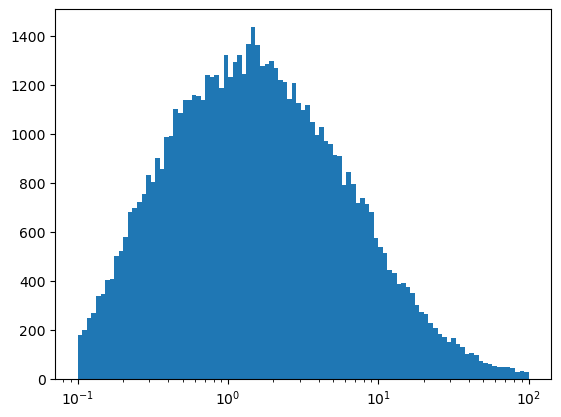

In [6]:
plt.hist(np.array(sfcPrecipL),bins=10**np.linspace(-1,2,100))
plt.xscale('log')

In [77]:
with nc.Dataset('zKaSimL_KWAJ.nc') as f:
    zKaSimL_kwaj=f['zKaSim'][:,:]
    zWSimL_kwaj=f['zWSim'][:,:]
    sfcPrecipL_kwaj=f['sfcPrecip'][:]
    piaKaL_kwaj=f['piaKa'][:]

with nc.Dataset('zKaSimL_CONUS.nc') as f:
    zKaSimL_conus=f['zKaSim'][:,:]
    zWSimL_conus=f['zWSim'][:,:]
    sfcPrecipL_conus=f['sfcPrecip'][:]
    piaKaL_conus=f['piaKa'][:]

# concatenate the two datasets
zKaSimL=np.concatenate((zKaSimL_kwaj,zKaSimL_conus),axis=0)
zWSimL=np.concatenate((zWSimL_kwaj,zWSimL_conus),axis=0)
sfcPrecipL=np.concatenate((sfcPrecipL_kwaj,sfcPrecipL_conus),axis=0)
piaKaL=np.concatenate((piaKaL_kwaj,piaKaL_conus),axis=0)

zKaSimL=np.array(zKaSimL)
zWSimL=np.array(zWSimL)
zKaSimL[zKaSimL<12]=0
zWSimL[zWSimL<-5]=-5
piaKaL=np.array(piaKaL)
print(zWSimL.shape)

(87540, 21)


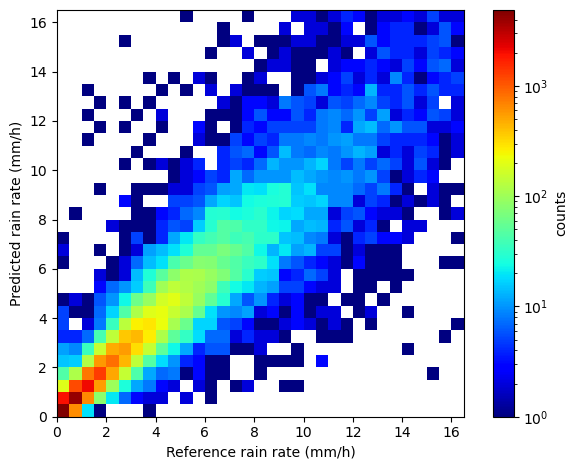

In [93]:
piaKan=np.array(piaKaL)+np.random.normal(0,2.5,len(piaKaL))
xL=np.concatenate([(zKaSimL[:,-11:]-20)/10,(zWSimL[:,-15:]-5)/10,piaKan[:,np.newaxis]/10],axis=1)
yL=np.array(sfcPrecipL)
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(xL, yL, test_size=0.5, random_state=42)

from sklearn.neighbors import KNeighborsRegressor

neigh = KNeighborsRegressor(n_neighbors=40,weights='distance')
import lightgbm as lgb
#lgbmReg=lgb.LGBMRegressor(n_estimators=1000,learning_rate=0.01,num_leaves=200,objective="mse",random_state=42)
#lgbmReg.fit(x_train,y_train)
neigh.fit(x_train, y_train)
y_pred=neigh.predict(x_test)
y_predLGBM=neigh.predict(x_test)
from matplotlib.colors import LogNorm
ax=plt.subplot(111)
h2=plt.hist2d(y_test,y_pred,bins=np.arange(34)*0.5,norm=LogNorm(),cmap='jet')
ax.set_aspect('equal')
plt.xlabel('Reference rain rate (mm/h)')
plt.ylabel('Predicted rain rate (mm/h)')
c=plt.colorbar(label='counts')
plt.tight_layout()
plt.savefig('knnRegrPrecipKaW_CONUS_KWAJ.png')


np.corrcoef(y_test,y_predLGBM)
a=np.nonzero(np.abs(y_test-10)<2)




[0.1536916489175182, 0.029713064186574278, -0.0064863253122860376, -0.020962959109713294]
[0.5390861285937376, 0.40423442317846286, 0.3041772562928121, 0.48476150806507545]


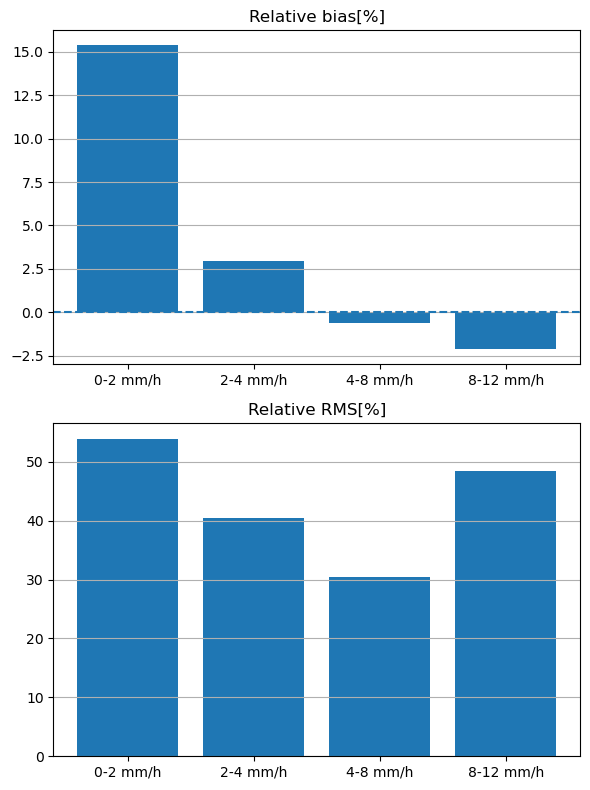

In [94]:
evalInt=[[0,2],[2,4],[4,8],[8,12]]
biasL=[]
rmsL=[]
for int1 in evalInt:
    a=np.nonzero((y_test>=int1[0]) & (y_test<int1[1]))
    bias=np.mean(y_predLGBM[a]-y_test[a])/np.mean(y_test[a])
    rms=np.sqrt(np.mean((y_predLGBM[a]-y_test[a])**2))/np.mean(y_test[a])
    biasL.append(bias)
    rmsL.append(rms)
plt.figure(figsize=(6,8))
plt.subplot(211)
cat=['0-2 mm/h','2-4 mm/h','4-8 mm/h','8-12 mm/h']
plt.bar(cat,np.array(biasL)*100)
#plt.axes().xaxis.set_visible(False)
plt.axhline(y=0,linestyle='--')
plt.grid(axis='y')

plt.title('Relative bias[%]')

plt.subplot(212)
plt.bar(cat,np.array(rmsL)*100)
plt.grid(axis='y')
plt.title('Relative RMS[%]')
plt.tight_layout()
plt.savefig('knnRegrPrecipScoresKaW_CONUS_KWAJ.png')

print(biasL)
print(rmsL)

In [39]:
import importlib
importlib.reload(simCMB)
dr=0.25
msflag=1
#zKaSim,zkaSfc,kexttot,salbtot,asym1D,\
#        zKa_true,zms,piaKa2d,piaKu2d,zKuSim,pRate
import importlib
#import lkTables as lkT
import lkTables
importlib.reload(lkTables)
lkTables_=lkTables.scattTables()
#print(dir(lkTables_))
print(lkTables_.zWR.shape)
print(lkTables_.salbR.max())
print(lkTables_.asymR.max())


simCMB is being imported
0.7267032
(289,)
0.52590275
0.7267032


In [12]:
print(lkT.scattTables.zWS.shape)
print(lkT.scattTables.zKaS.shape)
print(lkT.scattTables.zWR.shape)

(253,)
(253,)
(253,)


(741, 8, 88)


(87.5, 25.0)

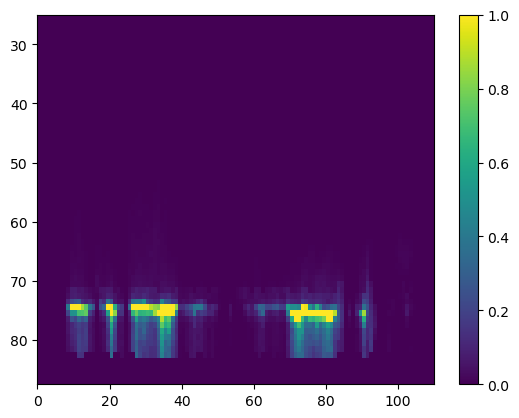

In [80]:
asym1D.shape
asym1D[380,:,:,3].max()
print(salbtot.shape)
plt.pcolormesh(salbtot[360:470,4,:].T,vmin=0,vmax=1)
plt.colorbar()
plt.ylim(175/2,50/2)

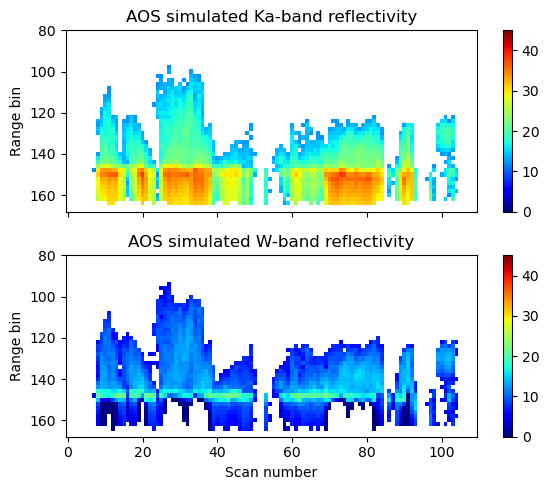

In [41]:
zkaSim_m=np.ma.masked_where(zms<12,zms)
zkatrue_m=np.ma.masked_where(zKa_true<12,zKa_true)
zwSim_m=np.ma.masked_where(zWSim<-10,zWSim)
plt.figure(figsize=(6,5))
ax=plt.subplot(212)
plt.pcolormesh(np.arange(360,470)-360,np.arange(88)*2,zwSim_m[360:470,4,:].T,vmin=0,vmax=45,cmap='jet')
plt.ylim(168,80)
plt.xlabel('Scan number')
plt.colorbar()
plt.ylabel('Range bin')
plt.title("AOS simulated W-band reflectivity")
ax=plt.subplot(211)
plt.pcolormesh(np.arange(360,470)-360,np.arange(88)*2,zkaSim_m[360:470,4,:].T,vmin=0,vmax=45,cmap='jet')
plt.ylim(168,80)
ax.xaxis.set_ticklabels([])

plt.ylabel('Range bin')
plt.title("AOS simulated Ka-band reflectivity")
plt.colorbar()
plt.tight_layout()
plt.savefig('simAOSKa.png')

In [2]:
print(len(cmbOrbL))
print(len(orbL))
print(orbL[0])
fname=orbL[0].replace("DPR.V9-20211125","DPRGMI.CORRA2022")
icount=0
for f in orbL:
    fname=f.replace("DPR.V9-20211125","DPRGMI.CORRA2022")
    fname=fname.replace("2A-CS-","2B-CS-")
    if fname in cmbOrbL:
        icount+=1
        #print(icount)
        continue
    #break
print(fname)
print(f)
print(cmbOrbL[0])
print(icount)

659
653
/Users/mgrecu/GPM/ORO_old/2A-CS/2A-CS-CONUS.GPM.DPR.V9-20211125.20190501-S011631-E012509.029377.V07A.HDF5
/Users/mgrecu/GPM/ORO_old/2A-CS/2B-CS-CONUS.GPM.DPRGMI.CORRA2022.20191021-S060735-E061606.032071.V07A.HDF5
/Users/mgrecu/GPM/ORO_old/2A-CS/2A-CS-CONUS.GPM.DPR.V9-20211125.20191021-S060735-E061606.032071.V07A.HDF5
/Users/mgrecu/GPM/ORO_old/2A-CS/2B-CS-CONUS.GPM.DPRGMI.CORRA2022.20190501-S011631-E012509.029377.V07A.HDF5
653


In [33]:
import numpy as np
def readOrb(orb):
    fh=Dataset(orb)
    sfcPrecip=fh['FS/SLV/precipRateNearSurface'][:,:]
    precipRate=fh['FS/SLV/precipRate'][:,:]
    lon=fh['FS/Longitude'][:,:]
    lat=fh['FS/Latitude'][:,:]
    hzero=fh['FS/VER/heightZeroDeg'][:,:]
    pType=fh['FS/CSF/typePrecip'][:,:]
    stormTop=fh['FS/PRE/heightStormTop'][:,:]
    pType=(pType/1e7).astype(np.int32)
    bzd=fh['FS/VER/binZeroDeg'][:,:]
    zku=fh['FS/PRE/zFactorMeasured'][:,:,:,0]
    zka=fh['FS/PRE/zFactorMeasured'][:,:,:,1]
    bcf=fh['FS/PRE/binClutterFreeBottom'][:,:]
    bsfc=fh['FS/PRE/binRealSurface'][:,:]
    piah=fh['FS/SRT/PIAhybrid'][:,:]
    piaFinal=fh['FS/SLV/piaFinal'][:,:]
    dm_dpr=fh['FS/SLV/paramDSD'][:,:,:,1]
    zCorrected_dpr=fh['FS/SLV/zFactorFinal'][:,:,:,0]
    return sfcPrecip,hzero,pType,stormTop,bzd,zku,zka,bcf,precipRate,bsfc,piah,fh,piaFinal,dm_dpr,zCorrected_dpr

In [34]:
orbL=sorted(glob.glob("/Users/mgrecu/GPM/ORO_old/2A-CS/2A-CS*CONUS*HDF5"))
print(len(orbL))
convPixelsL=[]
totalRainL=[]
d={}
import tqdm
for orb in tqdm.tqdm(orbL[:1]):
    sfcPrecip,hzero,pType,stormTop,bzd,zku,zka,bcf,precipRate,bsfc,piah,fh,piaFinal,dm_dpr,zCorrected_dpr=readOrb(orb)
    break
    a=np.nonzero(pType==2)
    convPixelsL.append(len(a[0]))
    fname=orb.split("/")[-1]
    totalRainL.append(np.sum(sfcPrecip[a]))
    d[fname]=(len(a[0]),np.sum(sfcPrecip[a]))

653


  0%|          | 0/1 [00:00<?, ?it/s]


In [33]:
#h1=plt.hist(convPixelsL,bins=100)
a=np.nonzero(np.array(convPixelsL)>700)
print(len(a[0]))
orbL=np.array(orbL)
for f1 in orbL[a[0]]:
    sfcPrecip,hzero,pType,stormTop,bzd,zku,zka,bcf,precipRate,bsfc,piah,fh=readOrb(f1)
    n=zku.shape[0]
    n3=n//3
    for k in range(3):
        plt.subplot(3,2,2*k+1)
        plt.pcolormesh(zku[k*n3:k*n3+n3,24,:].T,vmin=0,vmax=50,cmap="jet")
    #plt.pcolormesh(sfcPrecip.T,vmin=0,vmax=50,cmap="jet")
        plt.ylim(175,50)
        plt.subplot(3,2,2*k+2)
        plt.pcolormesh(zka[k*n3:k*n3+n3,24,:].T,vmin=0,vmax=30,cmap="jet")
    #plt.pcolormesh(sfcPrecip.T,vmin=0,vmax=50,cmap="jet")
        plt.ylim(175,50)
    plt.savefig(f1.split("/")[-1]+".png")
    plt.close('all')
print(zku.shape)

60
(741, 49, 176)


In [8]:
import netCDF4 as nc
def readCMB(fname): # reads relevant data from the CMB file
    fh_cmb=nc.Dataset(fname)
    dZ=0 # offset between the CMB and DPR
    qv=fh_cmb["KuKaGMI/vaporDensity"][:,:,:]
    press=fh_cmb["KuKaGMI/airPressure"][:,:,:]
    envNodes=fh_cmb["KuKaGMI/envParamNode"][:,:,:]
    airTemp=fh_cmb["KuKaGMI/airTemperature"][:,:,:]
    #skTemp=fh_cmb["KuKaGMI/skinTemperature"][:,:]
    binNodes=fh_cmb["KuKaGMI/phaseBinNodes"][:,:]
    pwc=fh_cmb["KuKaGMI/precipTotWaterCont"][:,:,:]
    #sfcEmiss=fh_cmb["KuKaGMI/surfEmissivity"][:,:,:]
    dm=fh_cmb["KuKaGMI/precipTotDm"][:,:,:]
    #cldw=fh_cmb["KuKaGMI/cloudLiqWaterCont"][:,:,:]
    sfcBin=fh_cmb["KuKaGMI/Input/surfaceRangeBin"][:,:,:]
    zCorrected=fh_cmb["KuGMI/correctedReflectFactor"][:,:,:]+dZ
    piaEffective=fh_cmb["KuKaGMI/Input/piaEffective"][:,:,:]
    piaEffectiveFlag=fh_cmb["KuKaGMI/Input/piaEffectiveReliabFlag"][:,:,:]  
    nearSurfPrecipTotRate=fh_cmb["KuKaGMI/nearSurfPrecipTotRate"][:,:] 
    #pType=fh_cmb["KuKaGMI/Input/precipitationType"][:,:]
    #lon=fh_cmb["KuKaGMI/Longitude"][:,:]
    #lat=fh_cmb["KuKaGMI/Latitude"][:,:]
    return qv,press,envNodes,airTemp,binNodes,pwc,dm,sfcBin,zCorrected,pType,piaEffective,piaEffectiveFlag,nearSurfPrecipTotRate

In [39]:
ic=0
cfadKu=np.zeros((100,40))
cfadKa=np.zeros((100,40))
zku9L=[]
zka9L=[]
precipRate9L=[]
bzd9L=[]
bcf9L=[]
pType9L=[]
bsfc9L=[]
piah9L=[]
zCorrected9L=[]
dm9L=[]
binNodes9L=[]
qvL=[]
pressL=[]
envNodesL=[]
airTempL=[]
piaSRTFlagL=[]
piaSRTL=[]
piaFinal=[]
sfcPrecipCMBL=[]
zFinalL=[]
dm_dprL=[]
piaFinalL=[]
for f1 in orbL[:]:
    sfcPrecip,hzero,pType,stormTop,bzd,zku,zka,bcf,precipRate,bsfc,piah,fh,piaFinal,dm_dpr,zFinal=readOrb(f1)
    fname=f1.replace("DPR.V9-20211125","DPRGMI.CORRA2022")
    fname=fname.replace("2A-CS-","2B-CS-")
    if fname not in cmbOrbL:
        continue
    qv,press,envNodes,airTemp,binNodes,pwc,dm,sfcBin,zCorrected,pTypeCMB,piaSRT,piaSRTFlag,sfcPrecipCMB=readCMB(fname)
    #break
    ac=np.nonzero(pType==2)
    n=zku.shape[0]
    n1=zCorrected.shape[0]
    if n1!=n:
        print("mismatch")
        #continue
        break
    for i1,j1 in zip(ac[0],ac[1]):
        if hzero[i1,j1]>3500 and bcf[i1,j1]-bzd[i1,j1]>24 and stormTop[i1,j1]>4000:
            if i1>3 and i1<n-3 and j1>3 and j1<49-3:
                zCorrected9L.append(zCorrected[i1-3:i1+4,j1-3:j1+4,:])
                dm9L.append(dm[i1-3:i1+4,j1-3:j1+4,:])
                binNodes9L.append(binNodes[i1-3:i1+4,j1-3:j1+4,:])
                zku9L.append(zku[i1-3:i1+4,j1-3:j1+4,:])
                zka9L.append(zka[i1-3:i1+4,j1-3:j1+4,:])
                precipRate9L.append(precipRate[i1-3:i1+4,j1-3:j1+4])
                bzd9L.append(bzd[i1-3:i1+4,j1-3:j1+4])
                bcf9L.append(bcf[i1-3:i1+4,j1-3:j1+4])
                pType9L.append(pType[i1-3:i1+4,j1-3:j1+4])
                bsfc9L.append(bsfc[i1-3:i1+4,j1-3:j1+4,:])
                piah9L.append(piah[i1-3:i1+4,j1-3:j1+4,:])
                qvL.append(qv[i1-3:i1+4,j1-3:j1+4,:])
                pressL.append(press[i1-3:i1+4,j1-3:j1+4,:])
                envNodesL.append(envNodes[i1-3:i1+4,j1-3:j1+4,:])
                airTempL.append(airTemp[i1-3:i1+4,j1-3:j1+4,:])
                piaSRTFlagL.append(piaSRTFlag[i1-3:i1+4,j1-3:j1+4,:])
                piaSRTL.append(piaSRT[i1-3:i1+4,j1-3:j1+4,:])
                sfcPrecipCMBL.append(sfcPrecipCMB[i1-3:i1+4,j1-3:j1+4])
                zFinalL.append(zFinal[i1-3:i1+4,j1-3:j1+4,:])
                dm_dprL.append(dm_dpr[i1-3:i1+4,j1-3:j1+4,:])
                piaFinalL.append(piaFinal[i1-3:i1+4,j1-3:j1+4])
            ic+=1
            continue
            for k in range(bzd[i1,j1]-66,min(bzd[i1,j1]+34,bcf[i1,j1])):
                if zku[i1,j1,k]>12:
                    iz=int(zku[i1,j1,k])-12
                    if iz > 39:
                        iz=39
                    cfadKu[k-(bzd[i1,j1]-66),iz]+=1
                if zka[i1,j1,k]>12:
                    iz=int(zka[i1,j1,k])-12
                    if iz > 39:
                        iz=39
                    cfadKa[k-(bzd[i1,j1]-66),iz]+=1

In [27]:
print(fh['FS/SLV/paramDSD'][:,:,:,1].max())
print(fh['FS/SLV/zFactorFinal'])

2.19
<class 'netCDF4._netCDF4.Variable'>
float32 zFactorFinal(phony_dim_31, phony_dim_32, phony_dim_33, phony_dim_34)
    DimensionNames: nscan,nray,nbin,nfreq
    Units: dBZ
    units: dBZ
    _FillValue: -9999.9
    CodeMissingValue: -9999.9
path = /FS/SLV
unlimited dimensions: phony_dim_31
current shape = (741, 49, 176, 2)
filling on


In [11]:
print(f1)
print(piaSRTFlag.shape)
print(piaSRT.shape)

/Users/mgrecu/GPM/ORO_old/2A-CS/2A-CS-CONUS.GPM.DPR.V9-20211125.20190501-S011631-E012509.029377.V07A.HDF5
(741, 49, 2)
(741, 49, 2)


In [9]:
print(fh["FS/PRE/binRealSurface"].shape)
print(np.array(zCorrected9L).shape)

(732, 49, 2)
(33739, 7, 7, 88)


In [40]:
import xarray as xr 
zku9=xr.DataArray(np.array(zku9L),dims=['nt','n7','n7','nBins'])
zka9=xr.DataArray(np.array(zka9L),dims=['nt','n7','n7','nBins'])
precipRate9=xr.DataArray(np.array(precipRate9L),dims=['nt','n7','n7','nBins'])
bzd9=xr.DataArray(np.array(bzd9L),dims=['nt','n7','n7'])
bcf9=xr.DataArray(np.array(bcf9L),dims=['nt','n7','n7'])
pType9=xr.DataArray(np.array(pType9L),dims=['nt','n7','n7'])
bsfc9=xr.DataArray(np.array(bsfc9L),dims=['nt','n7','n7','n2'])
piah9=xr.DataArray(np.array(piah9L),dims=['nt','n7','n7','n2'])
zCorrected9=xr.DataArray(np.array(zCorrected9L),dims=['nt','n7','n7','nBins2'])
dm9=xr.DataArray(np.array(dm9L),dims=['nt','n7','n7','nBins2'])
binNodes9=xr.DataArray(np.array(binNodes9L),dims=['nt','n7','n7','n5'])
qv=xr.DataArray(np.array(qvL),dims=['nt','n7','n7','n10'])
press=xr.DataArray(np.array(pressL),dims=['nt','n7','n7','n10'])
envNodes=xr.DataArray(np.array(envNodesL),dims=['nt','n7','n7','n10'])
airTemp=xr.DataArray(np.array(airTempL),dims=['nt','n7','n7','n10'])
piaSRTFlag=xr.DataArray(np.array(piaSRTFlagL),dims=['nt','n7','n7','n2'])
piaSRT=xr.DataArray(np.array(piaSRTL),dims=['nt','n7','n7','n2'])
sfcPrecipCMB=xr.DataArray(np.array(sfcPrecipCMBL),dims=['nt','n7','n7'])
zFinal=xr.DataArray(np.array(zFinalL),dims=['nt','n7','n7','nBins'])
dm_dpr=xr.DataArray(np.array(dm_dprL),dims=['nt','n7','n7','nBins'])
piaFinal=xr.DataArray(np.array(piaFinalL),dims=['nt','n7','n7','n2'])


In [11]:
print(zku9.shape)
print(zka9.shape)
print(precipRate9.shape)
print(bzd9.shape)

(33739, 7, 7, 176)
(33739, 7, 7, 176)
(33739, 7, 7, 176)
(33739, 7, 7)


In [41]:

ds=xr.Dataset({'zku':zku9,'zka':zka9,'precipRate':precipRate9,'bzd':bzd9,'bcf':bcf9,'pType':pType9,\
               'bsfc':bsfc9,'piah':piah9,'zCorrected':zCorrected9,'dm':dm9,'binNodes':binNodes9,\
                'qv':qv,'press':press,'envNodes':envNodes,'airTemp':airTemp,'piaSRTFlag':piaSRTFlag,\
                    'piaSRT':piaSRT,'sfcPrecipCMB':sfcPrecipCMB,'zFinal':zFinal,'dm_dpr':dm_dpr,'piaFinal':piaFinal})


In [42]:

ds.to_netcdf("convectProfiles.nc",encoding={'zku':{'zlib':True,'complevel':5},'zka':{'zlib':True,'complevel':5},\
                                            'precipRate':{'zlib':True,'complevel':5},'bzd':{'zlib':True,'complevel':5},\
                                            'bcf':{'zlib':True,'complevel':5},'pType':{'zlib':True,'complevel':5},\
                                            'bsfc':{'zlib':True,'complevel':5},'piah':{'zlib':True,'complevel':5},\
                                            'zCorrected':{'zlib':True,'complevel':5},\
                                            'dm':{'zlib':True,'complevel':5},'binNodes':{'zlib':True,'complevel':5},\
                                            'qv':{'zlib':True,'complevel':5},'press':{'zlib':True,'complevel':5},\
                                            'envNodes':{'zlib':True,'complevel':5},'airTemp':{'zlib':True,'complevel':5},'piaSRTFlag':{'zlib':True,'complevel':5},\
                                            'piaSRT':{'zlib':True,'complevel':5},'sfcPrecipCMB':{'zlib':True,'complevel':5},\
                                            'zFinal':{'zlib':True,'complevel':5},'dm_dpr':{'zlib':True,'complevel':5},\
                                                'piaFinal':{'zlib':True,'complevel':5}})


35707


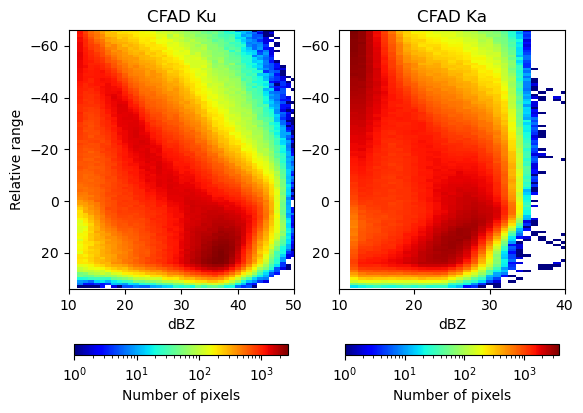

In [102]:
# save the cfadKu and cfadKa in netcdf format
import xarray as xr
ds=xr.Dataset({'cfadKu':xr.DataArray(cfadKu,dims=['nBins','nZ']),'cfadKa':xr.DataArray(cfadKa,dims=['nBins','nZ'])})
ds.to_netcdf("cfadDbz.nc",encoding={'cfadKu':{'zlib':True,'complevel':9},'cfadKa':{'zlib':True,'complevel':9}})
from matplotlib.colors import LogNorm
plt.subplot(1,2,1)
plt.pcolormesh(12+np.arange(40),arange(100)-66,cfadKu,cmap="jet",norm=LogNorm())
plt.title('CFAD Ku')
plt.ylabel('Relative range')
plt.xlabel('dBZ')
plt.ylim(34,-66)
plt.xlim(10,50)
plt.colorbar(orientation="horizontal",shrink=0.95,label="Number of pixels")
plt.subplot(1,2,2)
plt.title('CFAD Ka')
plt.pcolormesh(12+np.arange(40),arange(100)-66,cfadKa,cmap="jet",norm=LogNorm())
plt.ylim(34,-66)
plt.xlabel('dBZ')
#plt.ylabel('Relative range')
plt.xlim(10,40)
plt.colorbar(orientation="horizontal",shrink=0.95,label="Number of pixels")
plt.savefig("cfadDbz.png")
print(ic)

In [56]:
print(stormTop)

[[-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 ...
 [4018.7216796875 4883.18310546875 4848.7919921875 ... -- -- --]
 [4387.56640625 5162.22607421875 5206.08447265625 ... -- -- --]
 [4874.67333984375 5173.72705078125 6071.40185546875 ... -- -- --]]
